# Reasearch on OLS, 2OLS #


### 1. Import library

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
CPI_D = pd.read_csv('CPI.csv',encoding='utf-8-sig')
HOUSE_INDEX = pd.read_csv('houseindex.csv',encoding='utf-8-sig')
MORTAGECREDIT = pd.read_csv('mortgagecredit.csv',encoding='utf-8-sig')
MORTAGERATE = pd.read_csv('mortgagerate.csv',encoding='utf-8-sig')
NEW_HOME_SALES = pd.read_csv('newhomes.csv',encoding='utf-8-sig')
NEW_CONDOS = pd.read_csv('newcondos.csv',encoding='utf-8-sig')
UNEMPLOYED = pd.read_csv('unemplyed.csv',encoding='utf-8-sig')


In [ ]:
df = pd.merge(CPI_D, HOUSE_INDEX, on='REF_DATE', how='outer')  
df = pd.merge(df, MORTAGECREDIT, on='REF_DATE', how='outer') 
df = pd.merge(df, MORTAGERATE, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_HOME_SALES, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_CONDOS, on='REF_DATE', how='outer') 
df = pd.merge(df, UNEMPLOYED, on='REF_DATE', how='outer')
df['REF_DATE'] = pd.to_datetime(df['REF_DATE']) 
df['TimeTrend'] = np.arange(1, len(df) + 1)
df = df.dropna()  
df['TimeTrend'] = df['TimeTrend'] - 444
print(df)  
df.info()  

      REF_DATE    CPI  HINDEX     CREDIT  MRATE    HNUM    CNUM  URATE  \
444 1988-11-01   72.3    55.0   192308.0  11.78  8318.0  3844.0   10.2   
445 1988-12-01   72.3    55.8   194579.0  12.13  7249.0  2670.0    9.8   
446 1989-01-01   72.7    56.3   196837.0  12.24  5990.0  4667.0   11.3   
447 1989-02-01   73.2    57.7   199273.0  12.23  5024.0  2137.0   11.1   
448 1989-03-01   73.6    58.6   201617.0  12.41  6423.0  3310.0   11.0   
..         ...    ...     ...        ...    ...     ...     ...    ...   
818 2020-01-01  136.8   103.4  1640113.0   4.08  4000.0  2806.0    8.8   
819 2020-02-01  137.4   103.8  1644740.0   4.08  4302.0  4021.0    8.9   
820 2020-03-01  136.6   104.1  1652870.0   3.90  4655.0  4196.0   15.1   
821 2020-04-01  135.7   104.1  1662719.0   3.95  3603.0  5444.0   22.6   
826 2020-09-01  136.9   106.5  1705636.0   3.51  6395.0  5250.0   14.1   

     TimeTrend  
444          1  
445          2  
446          3  
447          4  
448          5  
..       

In [113]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 444 to 826
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   REF_DATE   255 non-null    datetime64[ns]
 1   CPI        255 non-null    float64       
 2   HINDEX     255 non-null    float64       
 3   CREDIT     255 non-null    float64       
 4   MRATE      255 non-null    float64       
 5   HNUM       255 non-null    float64       
 6   CNUM       255 non-null    float64       
 7   URATE      255 non-null    float64       
 8   TimeTrend  255 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 19.9 KB


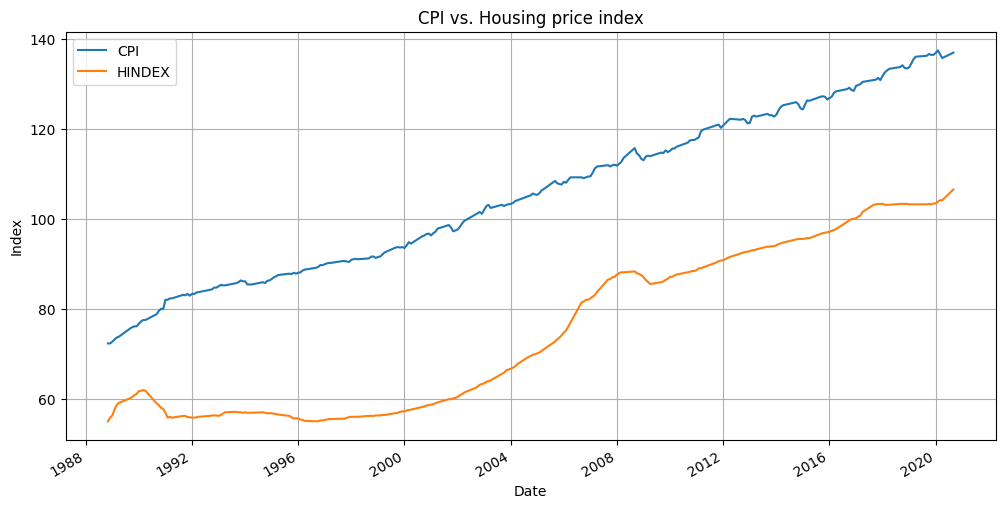

In [119]:
import matplotlib.pyplot as plt

# 示例：绘制 CPI 和 HINDEX 随时间变化
df.plot(x='REF_DATE', y=['CPI', 'HINDEX'], 
       figsize=(12, 6), title='CPI vs. Housing price index')
plt.xlabel('Date')
plt.ylabel('Index')
plt.grid(True)
plt.show()